### TTV analysis assuming i.i.d. Gaussian noise

In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
from jax import config, random
import numpyro, jax
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, init_to_value
config.update('jax_enable_x64', True)
numpyro.set_platform('cpu')
num_chains = 4
numpyro.set_host_device_count(num_chains)
print ('# jax device count:', jax.local_device_count())

# jax device count: 4


In [2]:
from jnkepler.jaxttv import JaxTTV
from jnkepler.jaxttv.infer import ttv_default_parameter_bounds, ttv_optim_curve_fit, scale_pdic
import corner

In [3]:
import seaborn as sns
sns.set(style='ticks', font_scale=1.6, font='times')
plt.rcParams["figure.figsize"] = (12,6)
from matplotlib import rc
rc('text', usetex=False)

### define tcobs, errorobs, p_init
- lists of length = (# of planets)
- elements of tcobs and errorobs: arrays of transit times and errors for each planet
- elements of p_init: (reasonably) good guesses for planets' mean periods

In [4]:
d = pd.read_csv("kep51/ttv.txt", sep="\s+", header=None, names=['tnum', 'tc', 'tcerr', 'dnum', 'planum'])
tcobs = [jnp.array(d.tc[d.planum==j+1]) for j in range(3)]
errorobs = [jnp.array(d.tcerr[d.planum==j+1]) for j in range(3)]
p_init = [45.155305, 85.31646, 130.17809] # rough initial guess
dt = 1.0
t_start, t_end = 155., 2950.
jttv = JaxTTV(t_start, t_end, dt, tcobs, p_init, errorobs=errorobs, print_info=True)

# number of transiting planets:    3
# integration starts at:           155.00
# first transit time in data:      159.11
# last transit time in data:       2945.75
# integration ends at:             2950.00
# integration time step:           1.0000 (1/45 of innermost period)



<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
/var/folders/69/wlx91x8s1x34mphlfjy0h4pm0000gn/T/ipykernel_11698/433985928.py:1: SyntaxWarning: invalid escape sequence '\s'
  d = pd.read_csv("kep51/ttv.txt", sep="\s+", header=None, names=['tnum', 'tc', 'tcerr', 'dnum', 'planum'])


### optimization

In [5]:
param_bounds = ttv_default_parameter_bounds(jttv)

/opt/homebrew/anaconda3/lib/python3.12/site-packages/jnkepler/jaxttv/infer.py:97: UserWarning: Bounds for cosi/lnode not provided: assuming coplanar orbits.
  warnings.warn(


# running least squares optimization...
# objective function: 41552.23 --> 47.72 (53 data)
# elapsed time: 6.5 sec


/opt/homebrew/anaconda3/lib/python3.12/site-packages/jnkepler/jaxttv/jaxttv.py:523: UserWarning: using t0 and P from a linear fit to the observed transit times.
  warnings.warn(


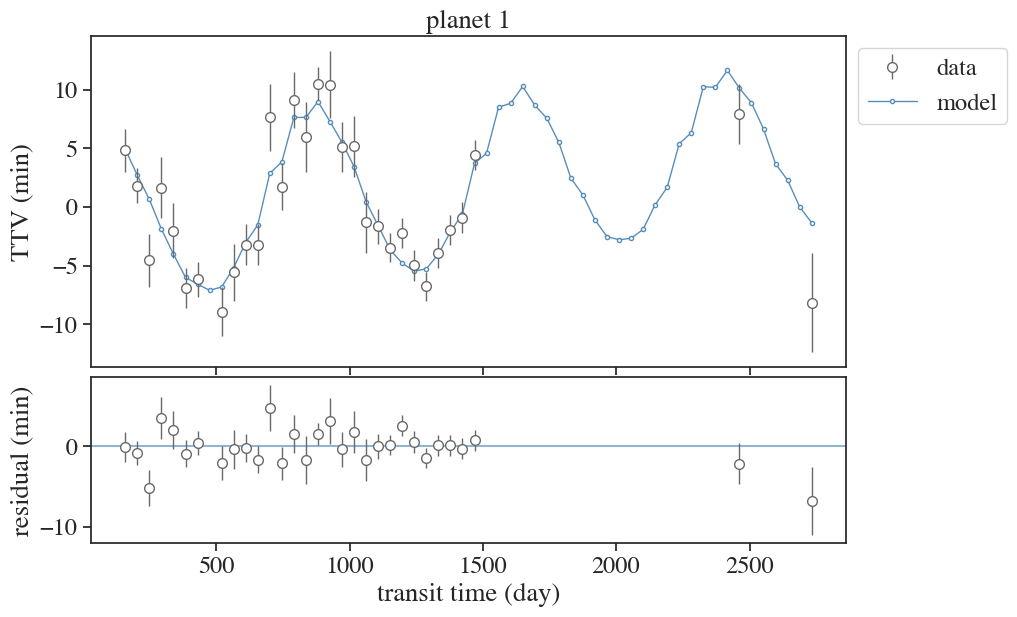

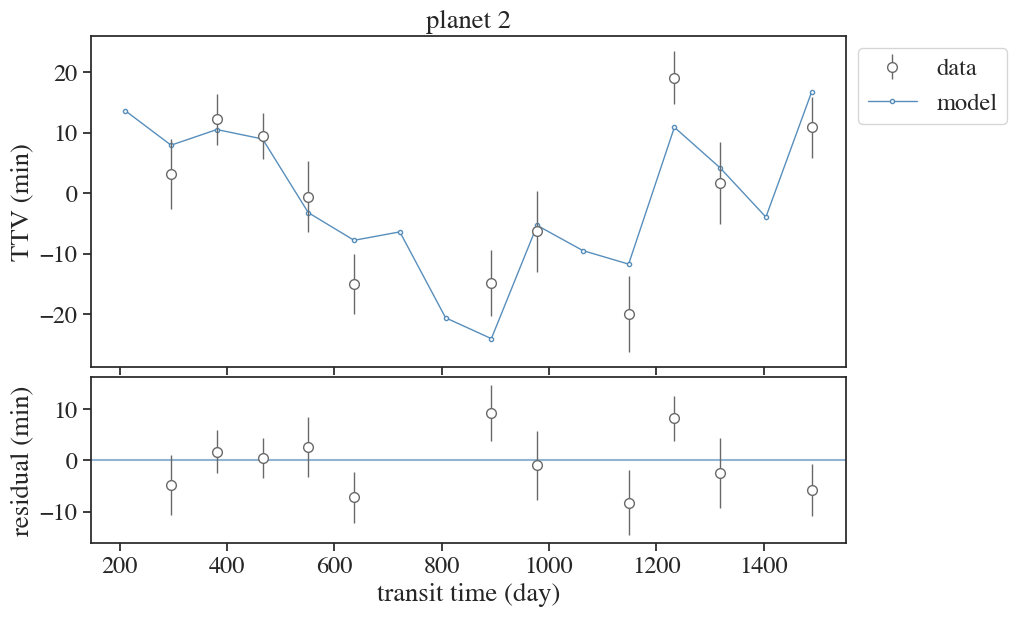

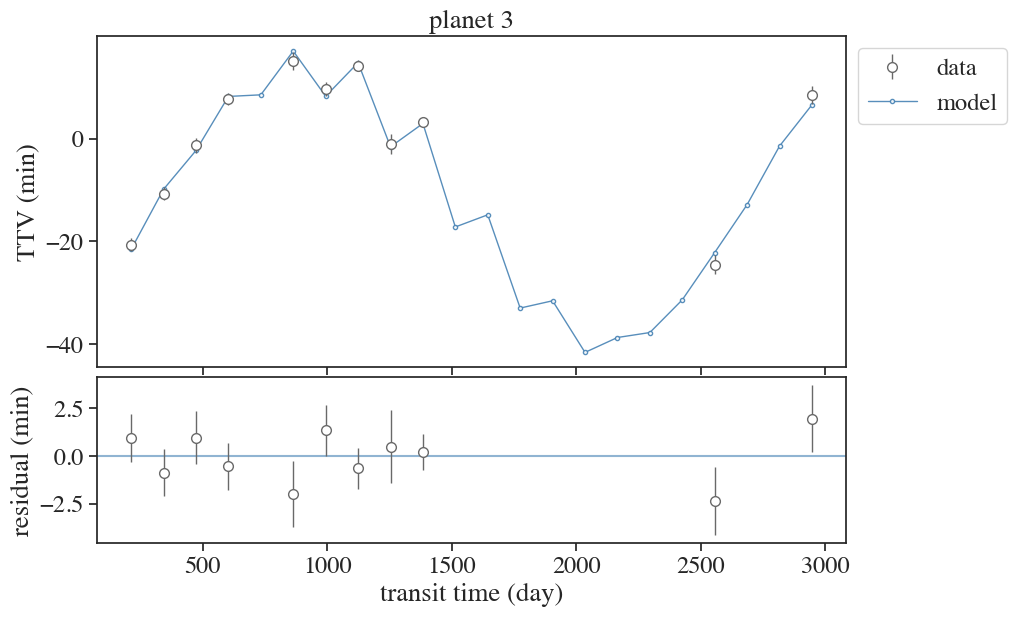

In [6]:
popt = ttv_optim_curve_fit(jttv, param_bounds)

In [7]:
popt

{'period': array([ 45.15410879,  85.31449733, 130.1841584 ]),
 'ecosw': array([-0.01706249,  0.01868955,  0.01153398]),
 'esinw': array([-0.04002236, -0.0342944 , -0.02762896]),
 'tic': array([159.11027203, 295.32100006, 212.02343432]),
 'lnpmass': array([-11.50342171, -11.30397137, -11.03635565]),
 'pmass': Array([1.00954905e-05, 1.23238842e-05, 1.61054047e-05], dtype=float64)}

### check precision & residual distribution

In [8]:
tc, _ = jttv.check_timing_precision(popt)

# fractional energy error (symplectic, dt=1.00e+00): 3.44e-09
# fractional energy error (symplectic, dt=4.52e-02): 7.15e-12
# max difference in tc: 6.15e-06 days (0.53 sec)


sample: 100%|█| 1000/1000 [00:01<00:00, 762.93it/s, 7 steps of size 4.95e-01. ac



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      lndf      3.29      0.88      3.42      2.00      4.59    144.57      1.01
     lnvar     -0.17      0.23     -0.17     -0.53      0.22    101.74      1.00

Number of divergences: 0


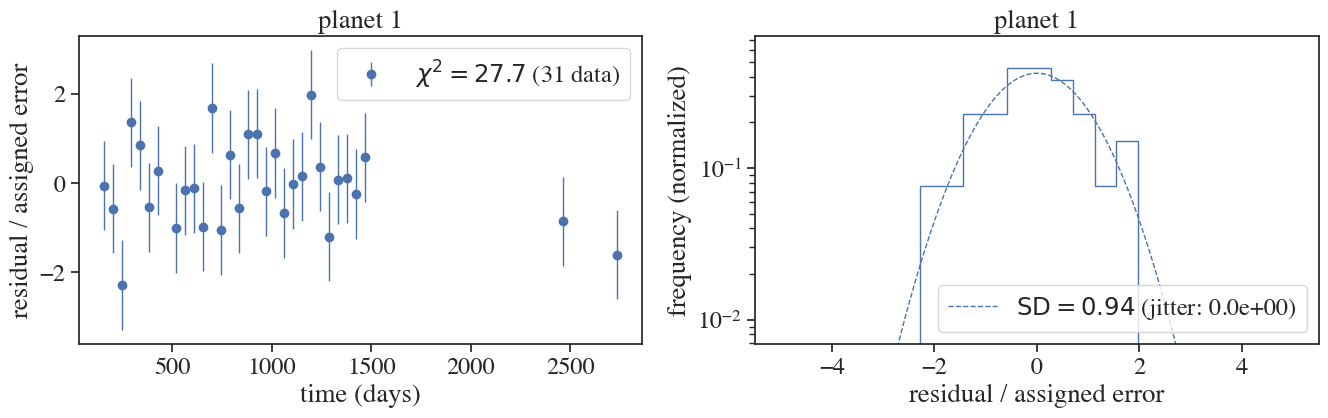

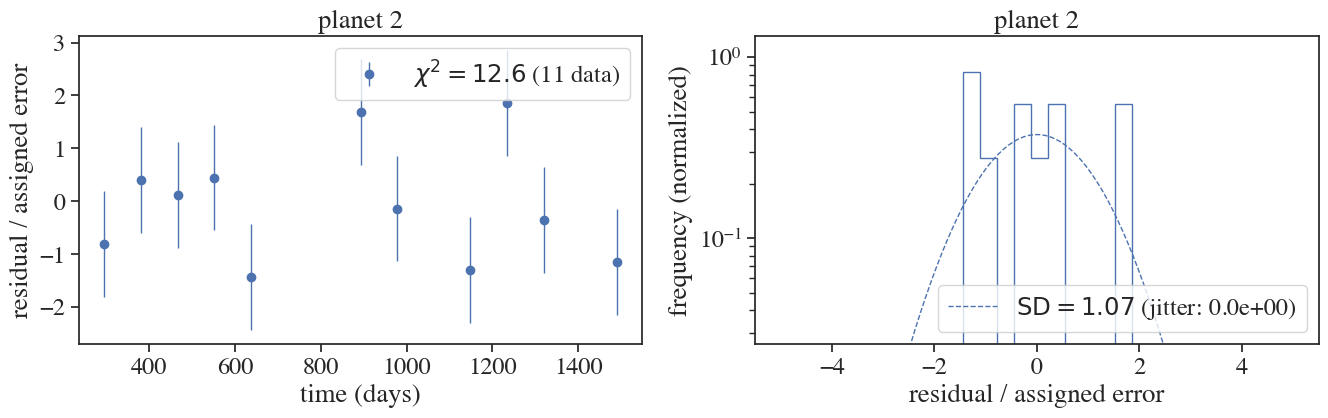

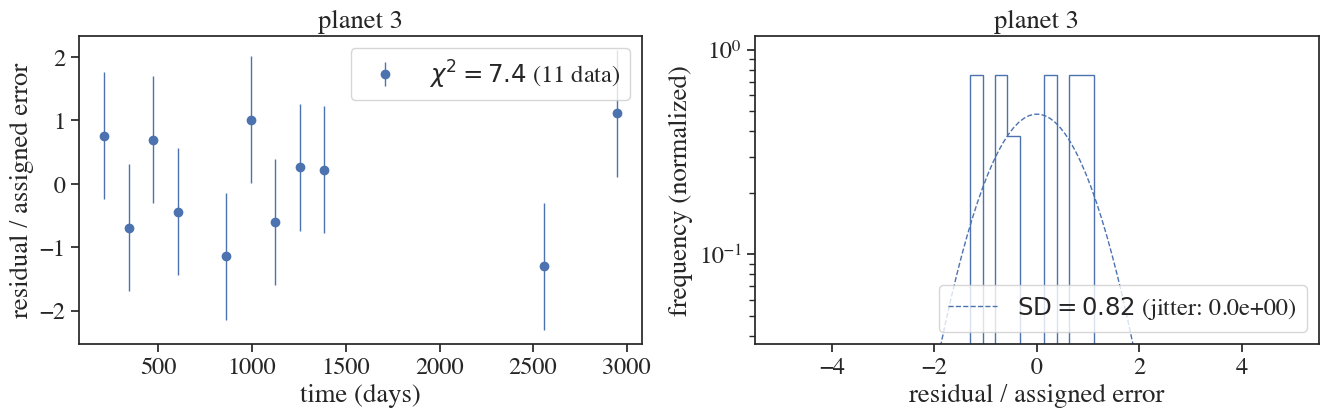

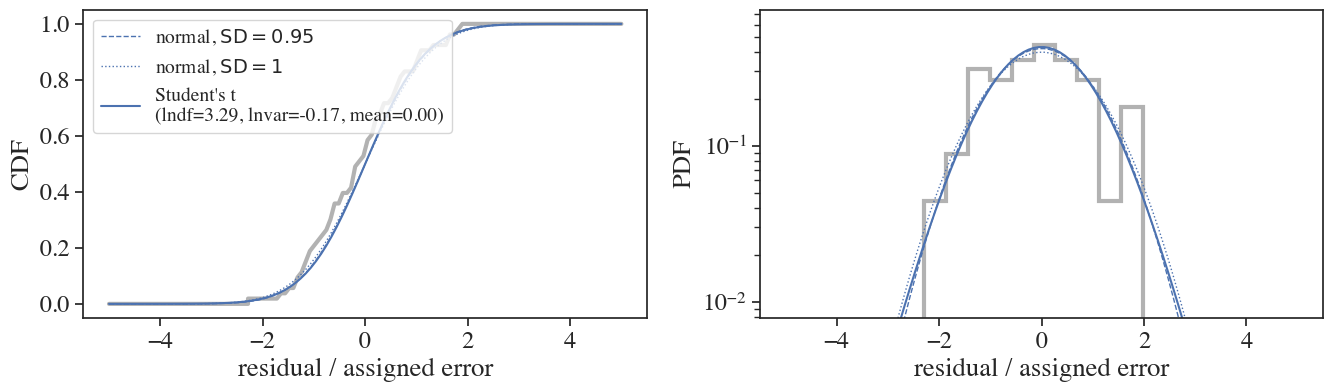

In [9]:
pdic_normal, pdic_student = jttv.check_residuals(popt)

### setup & run HMC

In [10]:
def model_scaled(sample_keys, param_bounds):
    """numpyro model for scaled parameters"""
    par = {}

    # sample parameters from priors
    for key in sample_keys:
        par[key+"_scaled"] = numpyro.sample(key+"_scaled", dist.Uniform(param_bounds[key][0]*0, param_bounds[key][0]*0+1.))
        par[key] = numpyro.deterministic(key, par[key+"_scaled"] * (param_bounds[key][1] - param_bounds[key][0]) + param_bounds[key][0])
    if "pmass" not in sample_keys:
        par["pmass"] = numpyro.deterministic("pmass", jnp.exp(par["lnpmass"]))
    
    # Jacobian for uniform ecc prior
    ecc = numpyro.deterministic("ecc", jnp.sqrt(par['ecosw']**2+par['esinw']**2))
    numpyro.factor("eprior", -jnp.log(ecc))

    # compute transit times
    tcmodel, ediff = jttv.get_transit_times_obs(par)
    numpyro.deterministic("ediff", ediff)
    numpyro.deterministic("tcmodel", tcmodel)
    
    # likelihood
    tcerrmodel = jttv.errorobs_flatten     
    numpyro.sample("obs", dist.Normal(loc=tcmodel, scale=tcerrmodel), obs=jttv.tcobs_flatten)

In [11]:
# physical parameters to sample from
sample_keys = ["ecosw", "esinw", "pmass", "period", "tic"] # uniform mass prior

In [12]:
# scaled parameters
pdic_scaled = scale_pdic(popt, param_bounds)

In [13]:
kernel = NUTS(model_scaled, 
            init_strategy=init_to_value(values=pdic_scaled), 
            dense_mass=True,
            #regularize_mass_matrix=False # this speeds up sampling for unknown reason
            )

In [14]:
mcmc = MCMC(kernel, num_warmup=10, num_samples=15, num_chains=num_chains)

In [15]:
# 4hr30min on M1 mac studio
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, sample_keys, param_bounds, extra_fields=('potential_energy', 'num_steps', 'adapt_state'))

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

In [16]:
mcmc.print_summary()


                      mean       std    median      5.0%     95.0%     n_eff     r_hat
 ecosw_scaled[0]      0.46      0.01      0.46      0.45      0.48      2.22   2240.00
 ecosw_scaled[1]      0.56      0.00      0.56      0.56      0.57       nan   1830.99
 ecosw_scaled[2]      0.54      0.00      0.54      0.54      0.55       nan    508.87
 esinw_scaled[0]      0.41      0.01      0.41      0.40      0.43       nan 602529.64
 esinw_scaled[1]      0.42      0.00      0.42      0.41      0.42       nan   5665.51
 esinw_scaled[2]      0.44      0.00      0.44      0.43      0.44       nan    426.51
period_scaled[0]      0.50      0.00      0.50      0.50      0.50      2.22     40.68
period_scaled[1]      0.50      0.00      0.50      0.50      0.50      2.22     53.94
period_scaled[2]      0.50      0.00      0.50      0.50      0.50      2.22     86.79
 pmass_scaled[0]      0.01      0.00      0.01      0.01      0.01       nan   2738.22
 pmass_scaled[1]      0.01      0.00      

In [17]:
# save results
import dill
with open("kep51_ttv_iidnormal.pkl", "wb") as f:
    dill.dump(mcmc, f)

### plot models drawn from posterior 

In [18]:
samples = mcmc.get_samples()

In [19]:
means, stds = jttv.sample_means_and_stds(samples)

/opt/homebrew/anaconda3/lib/python3.12/site-packages/jnkepler/jaxttv/jaxttv.py:523: UserWarning: using t0 and P from a linear fit to the observed transit times.
  warnings.warn(


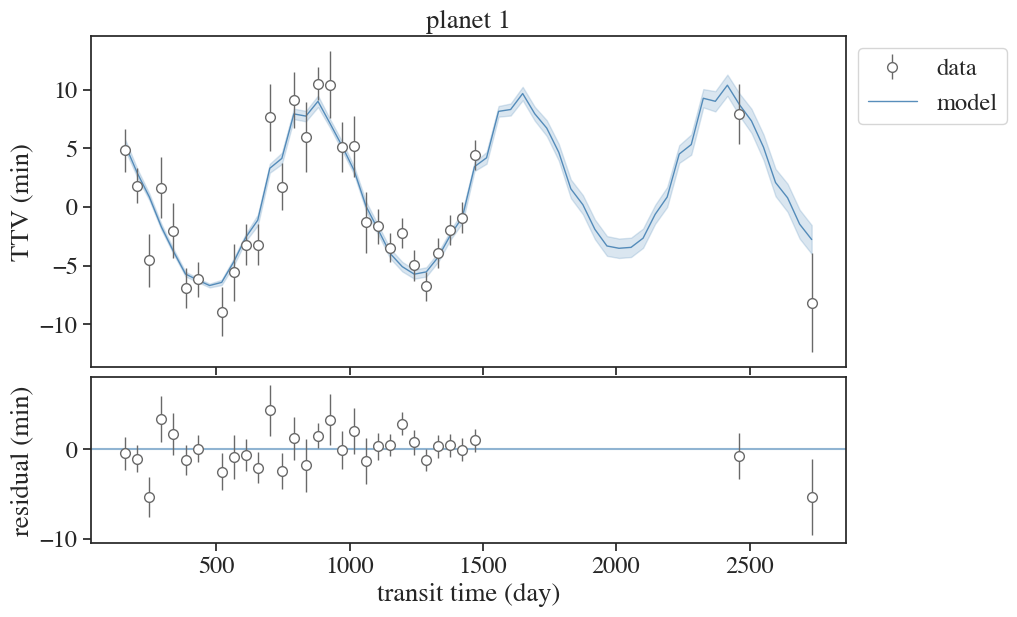

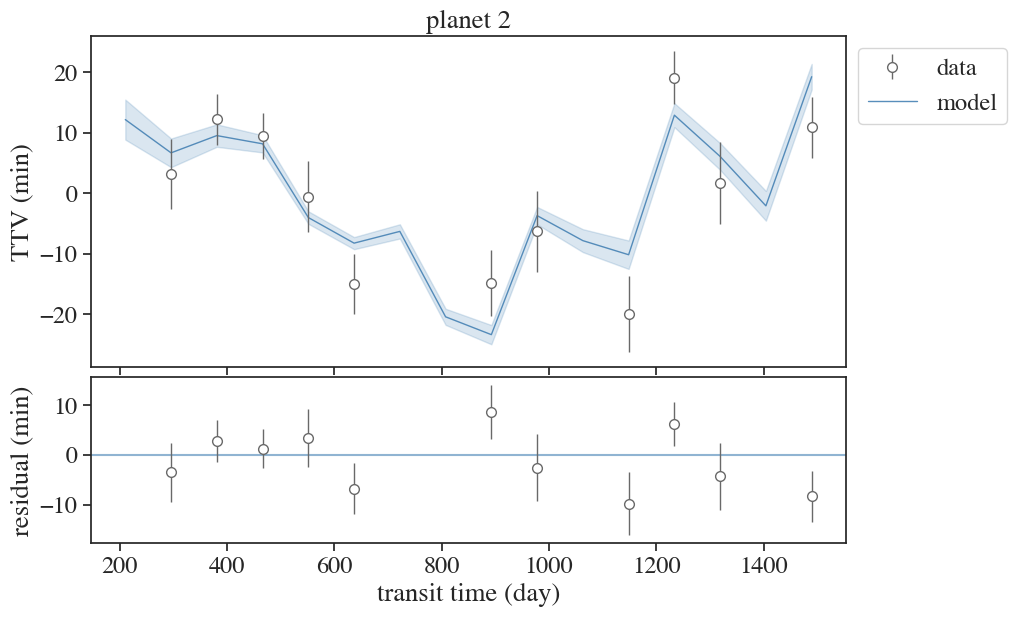

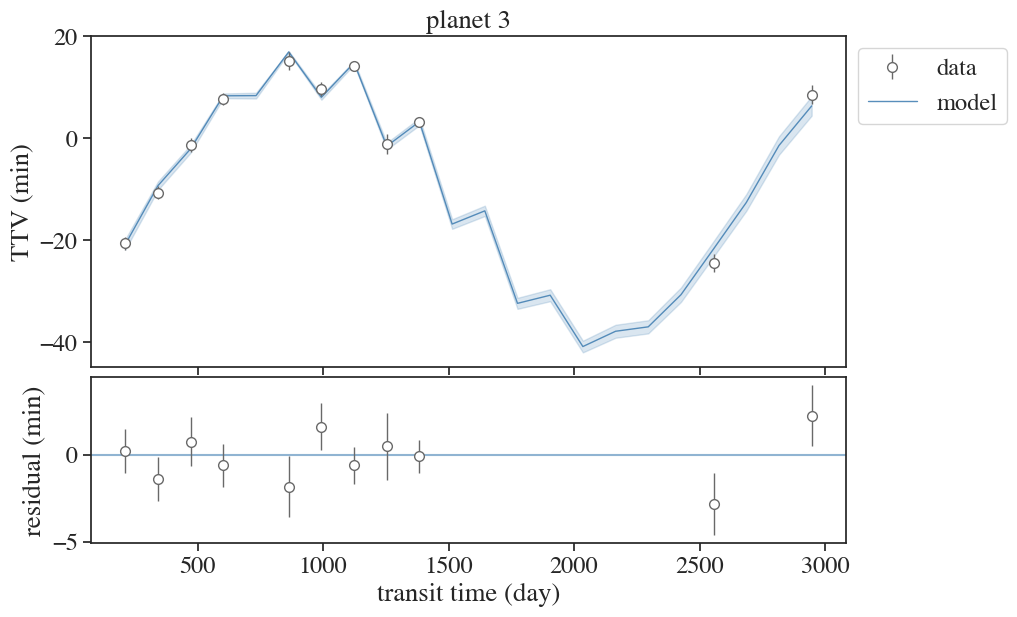

In [20]:
jttv.plot_model(means, tcmodelunclist=stds)

### trace and corner plots

/opt/homebrew/anaconda3/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/opt/homebrew/anaconda3/lib/python3.

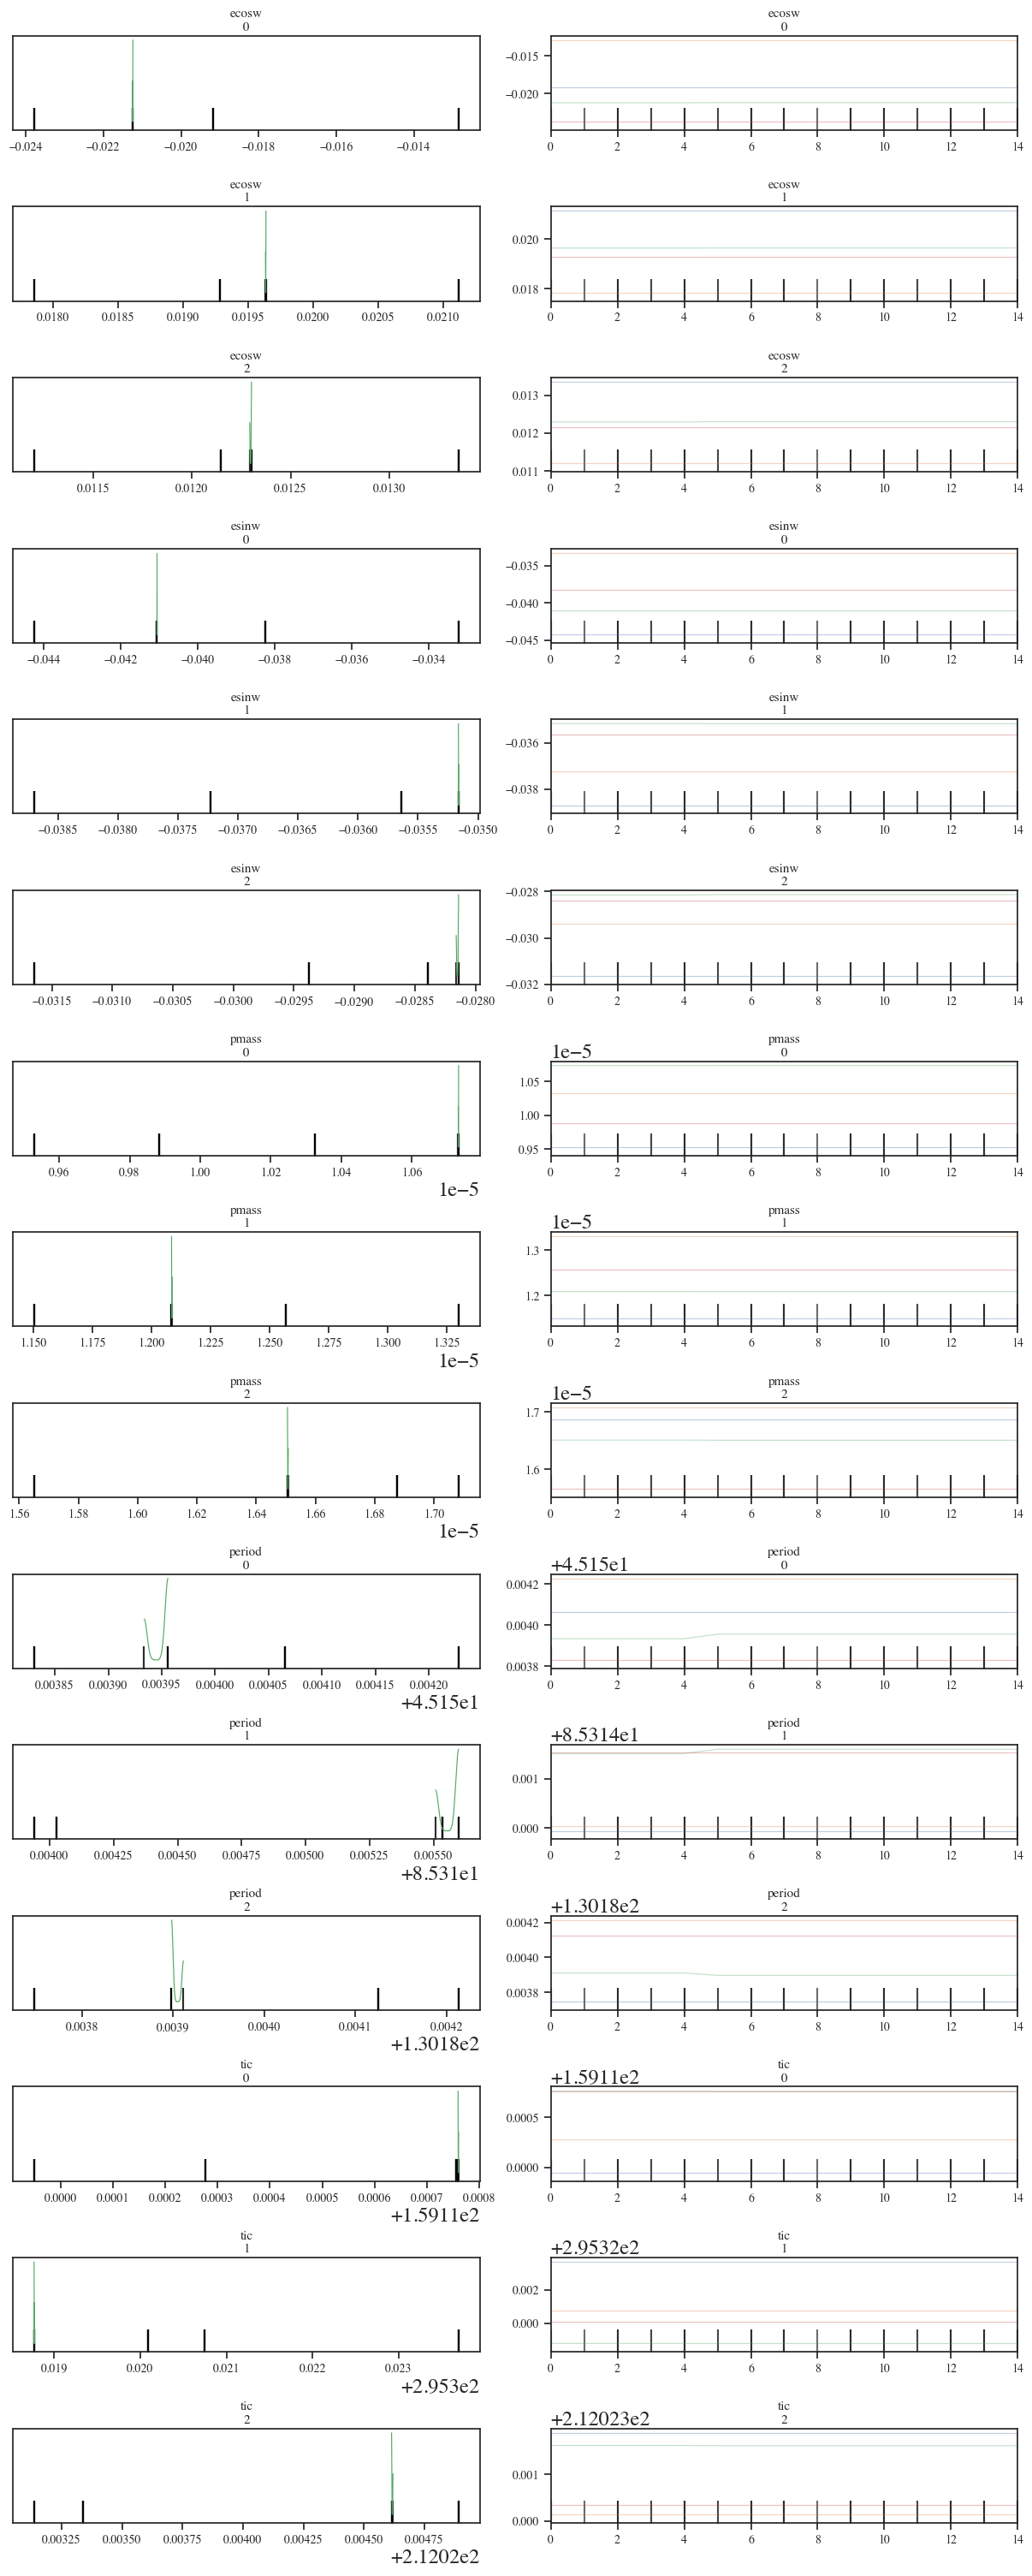

In [22]:
import arviz as az
idata = az.from_numpyro(mcmc)
fig = az.plot_trace(mcmc, var_names=sample_keys, compact=False)
plt.tight_layout(pad=0.2)

In [23]:
idata.posterior['mu'] = idata.posterior['pmass'] / 3.003e-6
names = ["period", "tic", "ecosw", "esinw", "mu"]
fig = corner.corner(idata, var_names=names, show_titles=True)

ImportError: Please install arviz or use a numpy array as input